In [31]:
import instrument as inst
import synthFM as synth

In [ ]:

import numpy as np   
import matplotlib.pyplot as plt
from consts import *
from tkinter import *
from slider import *
from adsr import *
from synthFM import *

class InstrumentHarmonic:
    def __init__(self,tk,name="FM synthetizer",amp=0.2,ratio=3,beta=0.6): 
        
        frame = LabelFrame(tk, text=name, bg="#808090")
        frame.pack(side=LEFT)
        # Synth params con sus sliders
        frameOsc = LabelFrame(frame, text="FM oscillator", bg="#808090")
        frameOsc.pack(side=LEFT, fill="both", expand="yes")
        
        self.ampS = Slider(frameOsc,'amp',packSide=TOP,
                           ini=amp,from_=0.0,to=1.0,step=0.05) 

        self.ratioS = Slider(frameOsc,'ratio',packSide=TOP,
                           ini=ratio,from_=0.0,to=20.0,step=0.5)
    
        self.betaS = Slider(frameOsc,'beta',packSide=TOP,
                            ini=beta,from_=0.0,to=10.0,step=0.05) 
        
        # una ventana de texto interactiva para poder lanzar notas con el teclado del ordenador
        text = Text(frameOsc,height=4,width=40)
        text.pack(side=BOTTOM)
        text.bind('<KeyPress>', self.down)
        text.bind('<KeyRelease>', self.up)

       
        # ADSR params con sus sliders
        frameADSR = LabelFrame(frame, text="ADSR", bg="#808090")
        frameADSR.pack(side=LEFT, fill="both", expand="yes", )
        self.attackS = Slider(frameADSR,'attack',
                           ini=0.01,from_=0.0,to=0.5,step=0.005,orient=HORIZONTAL,packSide=TOP) 

        self.decayS = Slider(frameADSR,'decay',
                           ini=0.01,from_=0.0,to=0.5,step=0.005,orient=HORIZONTAL,packSide=TOP)

        self.sustainS = Slider(frameADSR,'sustain',
                   ini=0.4,from_=0.0,to=1.0,step=0.01,orient=HORIZONTAL,packSide=TOP) 
                    
        self.releaseS = Slider(frameADSR,'release',
                   ini=0.5,from_=0.0,to=4.0,step=0.05,orient=HORIZONTAL,packSide=TOP) 


        
        # canales indexados por la nota de lanzamiento -> solo una nota del mismo valor
        self.channels = dict()        
        self.tails = dict()
                         

    # obtenemos todos los parámetros del sinte (puede servir para crear presets)
    def getConfig(self):
        return (self.ampS.get(),self.ratioS.get(),self.betaS.get(),
                self.attackS.get(), self.decayS.get(), self.sustainS.get(),
                self.releaseS.get())

    # activación de nota
    def noteOn(self,midiNote):
        # si está el dict de canales apagamos nota actual con envolvente de fadeout
        # y guardamos en tails. El next devolverá este tail y luego comenzará la nota
        if midiNote in self.channels:                   
            lastAmp = self.channels[midiNote].adsr.last # ultimo valor de la envolvente: inicio del fadeOut
            env = Env([(0,lastAmp),(CHUNK,0)]).next()   # envolvente             
            signal = self.channels[midiNote].next()     # señal          
            self.tails[midiNote] = env*signal           # diccionario de tails (notas apagadas) 

        # generamos un nuevo synth en un canal indexado con notaMidi
        # con los parámetros actuales del synth
        freq= freqsMidi[midiNote]
        self.channels[midiNote] = SynthFM(
                fc=freq,
                amp=self.ampS.get(), ratio=self.ratioS.get(), beta=self.betaS.get(),
                attack = self.attackS.get(), decay= self.decayS.get(),
                sustain=self.sustainS.get(), release=self.releaseS.get())
        freqTercera = freqsMidi[midiNote + 2]
        self.channels[midiNote + 2] = SynthFM(
                fc=freqTercera,
                amp=self.ampS.get(), ratio=self.ratioS.get(), beta=self.betaS.get(),
                attack = self.attackS.get(), decay= self.decayS.get(),
                sustain=self.sustainS.get(), release=self.releaseS.get())
        freqQuinta = freqsMidi[midiNote + 4]
        self.channels[midiNote + 4] = SynthFM(
                fc=freqQuinta,
                amp=self.ampS.get(), ratio=self.ratioS.get(), beta=self.betaS.get(),
                attack = self.attackS.get(), decay= self.decayS.get(),
                sustain=self.sustainS.get(), release=self.releaseS.get())
        freqSeptima = freqsMidi[midiNote + 6]
        self.channels[midiNote + 4] = SynthFM(
                fc=freqSeptima,
                amp=self.ampS.get(), ratio=self.ratioS.get(), beta=self.betaS.get(),
                attack = self.attackS.get(), decay= self.decayS.get(),
                sustain=self.sustainS.get(), release=self.releaseS.get())
        

    # apagar nota -> propagamos noteOff al synth, que se encargará de hacer el release
    def noteOff(self,midiNote):
        if midiNote in self.channels: # está el dict, release
            self.channels[midiNote].noteOff()
            self.channels[midiNote + 2].noteOff()
            self.channels[midiNote + 4].noteOff()
            self.channels[midiNote + 7].noteOff()


    # lectura de teclas de teclado como eventos tkinter
    def down(self,event):
        c = event.keysym

        # tecla "panic" -> apagamos todos los sintes de golpe!
        if c=='0': 
            self.stop()            
        elif c in teclas:
            midiNote = 48+teclas.index(c) # buscamos indice y trasnportamos a C3 (48 en midi)        
            print(f'noteOn {midiNote}')
            self.noteOn(midiNote)         # arrancamos noteOn con el instrumento 
            

    def up(self,event):
        c = event.keysym
        if c in teclas:
            midiNote = 48+teclas.index(c) # buscamos indice y hacemos el noteOff
            print(f'noteOff {midiNote}')
            self.noteOff(midiNote)

    # siguiente chunck del generador: sumamos señal de canales y hacemos limpia de silenciados
    def next(self):
        out = np.zeros(CHUNK)          
        for c in list(self.channels):            # convertimos las keys a lista para mantener la lista de claves original
            if self.channels[c].state == 'off':  # si no, modificamos diccionario en el bucle de recorrido de claves -> error 
                del self.channels[c]
            else: # si la nota está el diccionario de tails devolvemos el fadeout generado en noteOn y elminamos tail
                if c in self.tails:                  
                    out += self.tails[c]
                    del self.tails[c]
                else:
                    out += self.channels[c].next()
        return out        

    # boton del pánico
    def stop(self):
        self.channels = dict() # delegamos en el garbage collector
        # for c in list(self.channels): del self.channels[c]



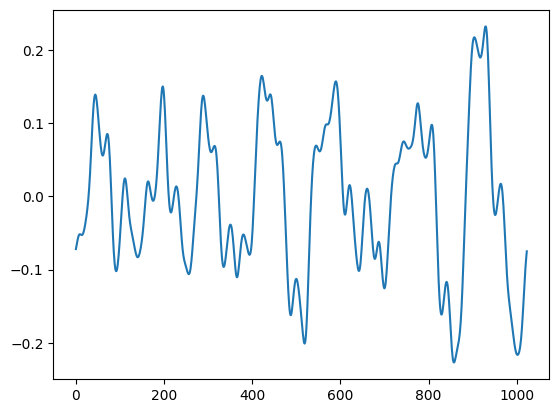

In [ ]:
# prueba de instrumento

import sounddevice as sd
import matplotlib.pyplot as plt
from tkinter import *

tk = Tk()
ins = InstrumentHarmonic(tk)
ins.amp = 1
ins.sustain=0.8

ins.noteOn(61)
signal = np.zeros(0)
for i in range(25):
    signal = np.concatenate((signal,ins.next()))

N = 1024
s = signal[-N:]

#ins.noteOn(70)
#signal2 = np.zeros(0)
#for i in range(25):
#    signal2 = np.concatenate((signal2,ins.next()))

#s = np.concatenate((s,signal2[:N]))

#tot = np.concatenate((signal,signal2))
tot = signal
sd.play(tot)
sd.wait()   



In [84]:
from tkinter import *
import os
import sounddevice as sd


def test():
    def callback(outdata, frames, time, status):    
        if status: print(status)    
        s = np.sum([i.next() for i in inputs],axis=0)
        s = np.float32(s)
        outdata[:] = s.reshape(-1, 1)

    tk = Tk()
    ins = InstrumentHarmonic(tk)
    inputs = [ins]

    # desactivar repeticion de teclas
    os.system('xset r off')

    stream = sd.OutputStream(samplerate=SRATE, channels=1, blocksize=CHUNK, callback=callback)    
    stream.start()
    tk.mainloop()

    # reactivar repeticion de teclas   
    os.system('xset r on')
    stream.close()

test()    


noteOn 59
noteOff 59
noteOn 59
noteOff 59
noteOn 57
noteOff 57
noteOn 60
noteOff 60
noteOn 62
noteOff 62
noteOn 64
noteOff 64
